# D3QN Agent with Prioritized Experience Replay
From this tutorial: [https://pylessons.com/CartPole-PER](https://pylessons.com/CartPole-PER)

In [2]:
import os
import gymnasium as gym
import random
import numpy as np

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Add
from keras.optimizers import Adam, RMSprop

from collections import deque
import matplotlib.pyplot as plt

2023-04-04 13:15:15.049881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 13:15:20.250097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def OurModel(input_shape, action_space, dueling=False):
    x_input = Input(input_shape)

    # 'Dense' is the basic form of a neural network layer
    # Input Layer of state size(4) and Hidden Layer with 512 nodes
    x = Dense(512, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(x_input)

    # Hidden layer with 256 nodes
    x = Dense(256, activation="relu", kernel_initializer='he_uniform')(x)

    # Hidden layer with 64 nodes
    x = Dense(64, activation="relu", kernel_initializer='he_uniform')(x)

    if dueling:
        state_value = Dense(1, kernel_initializer="he_uniform")(x)
        state_value = Lambda(lambda s: tf.expand_dims(s[:,0], -1), output_shape=(action_space,))(state_value)

        action_advantage = Dense(action_space, kernel_initializer="he_uniform")(x)
        action_advantage = Lambda(lambda a: a[:, :] - tf.reduce_mean(a[:, :], keepdims=True), output_shape=(action_space,))(action_advantage)

        x = Add()([state_value, action_advantage])
    else:
        # Output Layer with # of actions: 2 nodes (left, right)
        x = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(x)

    model = Model(inputs = x_input, outputs = x)
    model.compile(loss="mse", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

    model.summary()
    return model

In [4]:
class SumTree(object):
    data_pointer = 0

    # Here we initialize the tree with all nodes = 0, and initialize the data with all values = 0
    def __init__(self, capacity):
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity

        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema below
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)

        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)

    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1
        """ tree:
                0
               / \
              0   0
             / \ / \
        tree_index  0 0  0  We fill the leaves from left to right
        """

        self.data[self.data_pointer] = data

        # Update the leaf
        self.update(tree_index, priority)

        # Add 1 to data pointer
        self.data_pointer += 1

        if self.data_pointer >= self.capacity: # If we're above the capacity, we go back to first index (we overwrite)
            self.data_pointer = 0

    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority

        # Propagate the change through tree
        # Faaster than oop
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change

    def get_leaf(self, v):
        parent_index = 0

        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            # If we reach bottom, end search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else:
                # Downward search, always search for a higher priority node
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1
        return leaf_index, self.tree[leaf_index], self.data[data_index]

    @property
    def total_priority(self):
        return self.tree[0] # Return the root node

In [5]:
class Memory(object): # Stored as (state, action, reward, next_state) in SumTree
    PER_e = 0.01 # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6 # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.4 # Importance-sampling, from initial value increasing to 1

    PER_b_increment_per_sampling = 0.001

    absolute_error_upper = 1 # Clipped abs error

    def __init__(self, capacity):
        # Making the tree
        self.tree = SumTree(capacity)

    def store(self, experience):
        # Find max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])

        # If the max priority = 0 we can't put priority = 0 since this experience will never be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper

        self.tree.add(max_priority, experience)

    def sample(self, batch_size):
        # Create a minibatch array that will contains tbe minibatch
        minibatch = []

        b_idx = np.empty((batch_size,), dtype=np.int32)

        # Calculate the priority segment
        # As explained in the paper, we divide the range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / batch_size

        for i in range(batch_size):
            # A value is uniformly sampled from each range
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)

            # Experience that correspond to each value is retrieved
            index, priority, data = self.tree.get_leaf(value)

            b_idx[i] = index

            minibatch.append([data[0], data[1], data[2], data[3], data[4]])

        return b_idx, minibatch

    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e # Convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

In [8]:
class DQNAgent:
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.env.spec.max_episode_steps = 4000

        # By default cartpole-v1 has max episode steps = 500
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.MAX_EPISODES = 1000

        self.memory_per = Memory(10_000)
        self.memory = deque(maxlen=2000)

        self.GAMMA = 0.95

        self.epsilon = 1.0
        self.EPSILON_MIN = 0.01
        self.EPSILON_DECAY = 0.0005

        self.BATCH_SIZE = 32

        self.TRAIN_START = 1000

        self.TAU = 0.1 # Target network soft update hyperparameter

        self.ddqn = True
        self.soft_update = False # Use Soft update to update the target network?
        self.dueling = True # Use dueling network
        self.epsilon_greedy = True # Use epsilon greedy strategy
        self.use_PER = True

        self.save_path = 'models'
        self.scores, self.episodes, self.averages = [], [], []

        self.model_name = "CartPole-v1"

        if self.ddqn:
            if self.dueling:
                print("---------Dueling Double DQN---------")
                self.model_name = os.path.join(self.save_path, self.model_name + "_Dueling_DDQN_e_greedy.h5")
            else:
                print("---------Double DQN---------")
                self.model_name = os.path.join(self.save_path, self.model_name + "_DDQN_e_greedy.h5")
        else:
            print("---------Standard DQN---------")
            self.model_name = os.path.join(self.save_path, self.model_name + "_DQN.h5")

        # Create model
        self.model = OurModel(input_shape=(self.state_size, ), action_space=self.action_size, dueling=self.dueling)
        self.target_model = OurModel(input_shape=(self.state_size, ), action_space=self.action_size, dueling=self.dueling)

    def remember(self, state, action, reward, next_state, done):
        experience = state, action, reward, next_state, done
        if self.use_PER:
            self.memory_per.store(experience)
        else:
            self.memory.append((experience))

    def act(self, state, decay_step):
        if self.epsilon_greedy:
            # Epsilon greedy strategy
            # We use an improved version of epsilon greedy strategy for Q-Learning
            explore_probability = self.EPSILON_MIN + (self.epsilon - self.EPSILON_MIN) * np.exp(-self.EPSILON_DECAY * decay_step)
        else:
            # Old epsilon strategy
            if self.epsilon > self.EPSILON_MIN:
                self.epsilon *= (1 - self.EPSILON_DECAY)
            explore_probability = self.epsilon

        if explore_probability > self.epsilon:
            return random.randrange(self.action_size), explore_probability
        else:
            return np.argmax(self.model.predict(state, verbose=0)), explore_probability

    def replay(self):
        if self.use_PER:
            tree_idx, minibatch = self.memory_per.sample(self.BATCH_SIZE)
        else:
            minibatch = random.sample(self.memory, min(len(self.memory), self.BATCH_SIZE))

        state = np.zeros((self.BATCH_SIZE, self.state_size))
        next_state = np.zeros((self.BATCH_SIZE, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.BATCH_SIZE):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # Batch prediction to save speed
        target = self.model.predict(state, verbose=0)
        target_old = np.array(target)
        target_next = self.model.predict(next_state, verbose=0)
        target_val = self.target_model.predict(next_state, verbose=0)

        for i in range(self.BATCH_SIZE):
            # Correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                if self.ddqn:
                    # Double DQN (with slight variation by predicting next state using both main and target network)
                    a = np.argmax(target_next[i])
                    target[i][action[i]] = reward[i] + self.GAMMA * (target_val[i][a])
                else:
                    # Standard DQN
                    # DQN chooses the max Q value among next actions
                    # selection and evaluation of action is on the target Q Network
                    # Q_max = max_a' Q_target(s', a')
                    target[i][action[i]] = reward[i] + self.GAMMA * (np.amax(target_next[i]))

        if self.use_PER:
            indices = np.arange(self.BATCH_SIZE, dtype=np.int32)
            absolute_errors = np.abs(target_old[indices, np.array(action)] - target[indices, np.array(action)])
            self.memory_per.batch_update(tree_idx, absolute_errors)

        # Train the neural network
        self.model.fit(state, target, batch_size=self.BATCH_SIZE, verbose=0)

    def update_target_model(self):
        if not self.soft_update and self.ddqn:
            self.target_model.set_weights(self.model.get_weights())
        if self.soft_update and self.ddqn:
            q_model_theta = self.model.get_weights()
            target_model_theta = self.target_model.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[counter] = target_weight
                counter += 1
            self.target_model.set_weights(target_model_theta)

    plt.figure(figsize=(18, 9))
    def plot_model(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.averages.append(sum(self.scores[-50:]) / len(self.scores[-50:]))

        plt.plot(self.episodes, self.averages, 'r')
        plt.plot(self.episodes, self.scores, 'b')
        plt.ylabel('Score', fontsize=18)
        plt.ylabel('Steps', fontsize=18)

        dqn = "DQN_"
        soft_update = ""
        dueling = ""
        greedy = ""
        PER = ""

        if self.ddqn: dqn = 'DDQN_'
        if self.soft_update: soft_update = '_soft'
        if self.dueling: dueling = '_Dueling'
        if self.epsilon_greedy: greedy = '_Greedy'
        if self.use_PER: PER = "_PER"

        try:
            plt.savefig(dqn + "CartPole-v1" + soft_update + dueling + greedy + PER + ".png")
        except OSError:
            pass

        return str(self.averages[-1])[:5]

    def load(self, name):
        self.model = tf.keras.models.load_model(name)

    def save(self, name):
        self.model.save(name)

    def run(self):
        decay_step = 0
        for episode in range(self.MAX_EPISODES):
            state, _ = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                #self.env.render()
                decay_step += 1
                action, explore_probability = self.act(state, decay_step)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or i == self.env.spec.max_episode_steps -1:
                    reward = reward
                else:
                    reward = -100

                self.remember(state, action, reward, next_state, done)

                state = next_state
                i += 1

                if done:
                    # Every episode, update target model
                    self.update_target_model()

                    average = self.plot_model(i, episode)

                    print(f"Episode: {episode}/{self.MAX_EPISODES}, score: {i}, epsilon: {explore_probability:.2}, average: {average}")
                    if i == self.env.spec.max_episode_steps:
                        print("Saving trained model...")
                        self.save(self.model_name)
                        break

                self.replay()


    def test(self):
        self.load(self.model_name)
        for e in range(self.MAX_EPISODES):
            state, _ = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.MAX_EPISODES, i))
                    break

<Figure size 1800x900 with 0 Axes>

---------Dueling Double DQN---------
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 512)          2560        ['input_3[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 256)          131328      ['dense_10[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 64)           16448       ['dense_11[0][0]']               
                                                       


KeyboardInterrupt



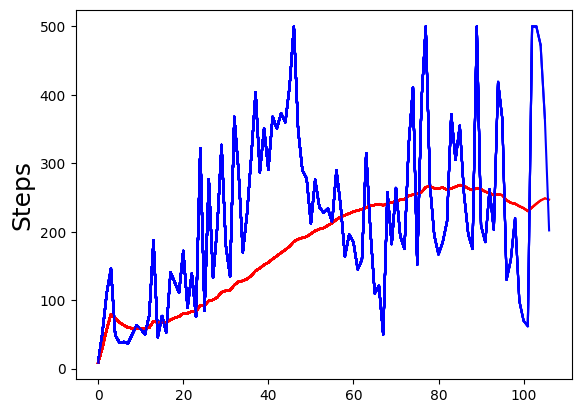

In [9]:
agent = DQNAgent()
agent.run()